In [1]:
import numpy as np

# Genetic algorithm

In [2]:
def quadratic_function(x):
    """
    Function x^2 + y^2 + 2z^2
    ---
    x : numpy.ndarray
        Input array of shape (3,)
    ---
    """
    return x[:, 0]**2 + x[:, 1]**2 + 2 * x[:, 2]**2

def rastrigin(x, A= 10):
    """
    Rastrigin function in 5 dimensions
    ---
    x : numpy.ndarray
        Input array of shape (m, n)
        m is the number of samples, n is the number of dimensions
    A : int
        Constant, default is 10
    ---
    """
    n = x.shape[1]
    return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x), axis=1)

In [3]:
class GeneticAlgorithm:
    def __init__(self, fitness_function, dim, pop_size, bounds, 
                 mutation_prob=0.2, mutation_strength=1.0,
                 crossover_prob=0.7, selection_pressure=0.5):
        """
        Initialize the Genetic Algorithm parameters.
        ---
        fitness_function : callable
            The fitness function to optimize.
        dim : int
            The number of dimensions of the problem.
        pop_size : int
            The size of the population.
        bounds : tuple
            The bounds for the variables (min, max).
        mutation_prob : float
            The probability of mutation.
        mutation_strength : float
            The strength of the mutation.
        crossover_prob : float
            The probability of crossover.
        selection_pressure : float
            The selection pressure for the selection process.
        ---
        """
        self.fitness_function = fitness_function
        self.dim = dim
        self.pop_size = pop_size
        self.bounds = bounds
        self.mutation_prob = mutation_prob
        self.mutation_strength = mutation_strength
        self.crossover_prob = crossover_prob
        self.selection_pressure = selection_pressure

        # Initialize the population
        self.population = np.random.uniform(
            low=self.bounds[0], 
            high=self.bounds[1], 
            size=(self.pop_size, self.dim)
        )

        # Initialize the best solution
        self.best_solution = None
        self.best_fitness = np.inf

        # History
        self.best_fitness_history = []
        self.avg_fitness_history = []

    def evaluate_population(self):
        """
        Evaluate the fitness of the current population.
        """
        fitness_values = self.fitness_function(self.population)
        
        # Sort the population based on fitness values
        sorted_indices = np.argsort(fitness_values)
        self.population = self.population[sorted_indices]
        fitness_values = fitness_values[sorted_indices]

        # Update best solution
        if fitness_values[0] < self.best_fitness:
            self.best_solution = np.copy(self.population[0])
            self.best_fitness = fitness_values[0]

        # Store fitness history
        self.best_fitness_history.append(fitness_values[0])
        self.avg_fitness_history.append(np.mean(fitness_values))

        return fitness_values
    
    def select_parents(self, fitness_values):
        """
        Select parents for the next generation using truncation selection.
        """
        total_fitness = np.sum(fitness_values)
        num_parents = max(2, int(self.pop_size * self.selection_pressure))
        return self.population[:num_parents]
    
    def crossover(self, parents):
        """
        Perform single-point crossover on the selected parents.
        """
        num_parents = parents.shape[0]
        num_offspring = self.pop_size - num_parents

        offspring = np.zeros((num_offspring, self.dim))

        # Select parent pairs
        parent1_indices = np.random.randint(0, num_parents, size=num_offspring)
        parent2_indices = np.random.randint(0, num_parents, size=num_offspring)

        # Handle same parents selection
        same_parents = parent1_indices == parent2_indices
        while np.any(same_parents):
            parent2_indices[same_parents] = np.random.randint(0, num_parents, size=np.sum(same_parents))
            same_parents = parent1_indices == parent2_indices

        parents1 = parents[parent1_indices]
        parents2 = parents[parent2_indices]

        # Pick crossover points
        crossover_points = np.random.randint(1, self.dim, size=num_offspring)

        # Pick which offspring will crossover
        will_crossover = np.random.rand(num_offspring) < self.crossover_prob

        for i in np.where(will_crossover)[0]:
            mask = np.zeros(self.dim, dtype=bool)
            mask[:crossover_points[i]] = True

            offspring[i] = np.where(mask, parents1[i], parents2[i])

        # Fill in the offspring that did not crossover
        offspring[~will_crossover] = parents1[~will_crossover]

        return offspring
    
    def mutate(self, offspring):
        """
        Perform gaussian mutation on the offspring.
        """
        num_offspring = offspring.shape[0]
        will_mutate = np.random.rand(num_offspring) < self.mutation_prob
        noise = np.random.normal(0, self.mutation_strength, offspring.shape)
        
        offspring[will_mutate] += noise[will_mutate]
        offspring = np.clip(offspring, self.bounds[0], self.bounds[1])

        return offspring
    
    def next_generation(self):
        """
        Generate the next generation of the population.
        """
        fitness_values = self.evaluate_population()
        parents = self.select_parents(fitness_values)
        offspring = self.crossover(parents)
        offspring = self.mutate(offspring)

        # Combine parents and offspring
        self.population = np.vstack((parents, offspring))

    def run(self, n_generations, display_every=1):
        """
        Run the genetic algorithm for a specified number of generations.
        ---
        n_generations : int
            The number of generations to run the algorithm.
        display_every : int
            The frequency of displaying the best fitness value.
        ---
        """
        for generation in range(n_generations):
            self.next_generation()
        
            if generation % display_every == 0 or generation == n_generations - 1:
                fitness_values = self.evaluate_population()
                best_fitness = np.min(fitness_values)
                print(f"Generation {generation}: Best Fitness = {best_fitness}")
        return self.best_solution, self.best_fitness, self.best_fitness_history, self.avg_fitness_history


# Functions for analysis

In [4]:
import matplotlib.pyplot as plt

In [5]:
def analyze_results(best_solution, best_fitness, best_fitness_history, avg_fitness_history):
    """
    Analyze the results of the genetic algorithm.
    ---
    best_solution : numpy.ndarray
        The best solution found by the algorithm.
    best_fitness : float
        The fitness value of the best solution.
    fitness_history : list
        The history of the best fitness values.
    avg_fitness_history : list
        The history of the average fitness values.
    ---
    """
    print(f"Best Solution: {best_solution}")
    print(f"Fitness value: {best_fitness}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(best_fitness_history, label='Best fitness')
    plt.plot(avg_fitness_history, label='Average fitness')
    plt.xlabel('Generation')
    plt.ylabel('Function value')
    plt.title('Genetic Algorithm Convergence')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.show()

# Quadratic function

In [6]:
ga_quadratic = GeneticAlgorithm(
    fitness_function=quadratic_function,
    dim=3,
    pop_size=100,
    bounds=(-5, 5),
    mutation_prob=0.2,
    mutation_strength=0.2,
    crossover_prob=0.8,
    selection_pressure=0.5
)

In [7]:
best_solution_quadratic, best_fitness_quadratic, best_fitness_history_quadratic, avg_fitness_history_quadratic = ga_quadratic.run(
    n_generations=1000,
    display_every=10
)

Generation 0: Best Fitness = 0.9782486968788329
Generation 10: Best Fitness = 0.05557244234880888
Generation 20: Best Fitness = 0.000938591680596221
Generation 30: Best Fitness = 0.0006438774554670484
Generation 40: Best Fitness = 0.0006438774554670484
Generation 50: Best Fitness = 0.0006438774554670484
Generation 60: Best Fitness = 0.0006438774554670484
Generation 70: Best Fitness = 0.0006438774554670484
Generation 80: Best Fitness = 0.0006438774554670484
Generation 90: Best Fitness = 0.0006438774554670484
Generation 100: Best Fitness = 0.0006438774554670484
Generation 110: Best Fitness = 0.0006438774554670484
Generation 120: Best Fitness = 0.0006438774554670484
Generation 130: Best Fitness = 0.0006438774554670484
Generation 140: Best Fitness = 0.0006438774554670484
Generation 150: Best Fitness = 0.0006438774554670484
Generation 160: Best Fitness = 0.0006438774554670484
Generation 170: Best Fitness = 0.0006438774554670484
Generation 180: Best Fitness = 0.0006438774554670484
Generation

Best Solution: [-0.00255926 -0.00285621 -0.00192772]
Fitness value: 2.2139986847212674e-05


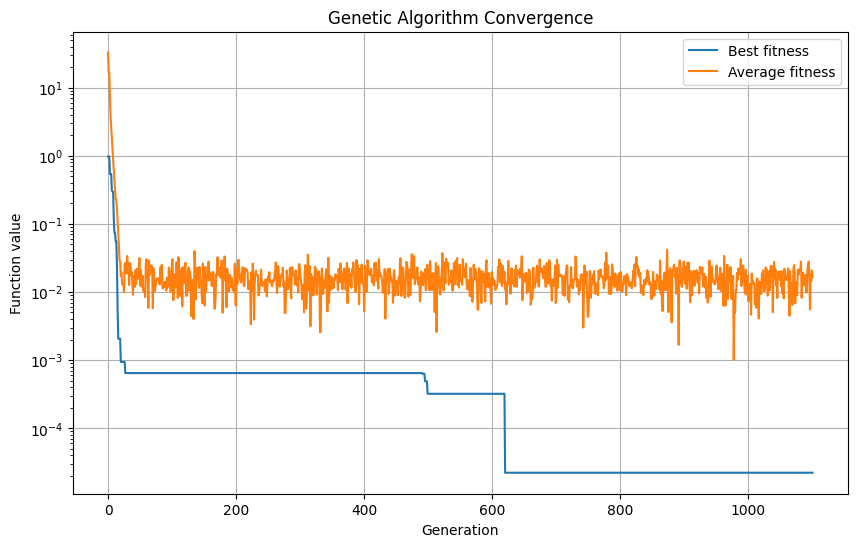

In [8]:
analyze_results(
    best_solution_quadratic,
    best_fitness_quadratic,
    best_fitness_history_quadratic,
    avg_fitness_history_quadratic
)

# 5d Rastrigin function

In [9]:
ga_rastrigin = GeneticAlgorithm(
    fitness_function=rastrigin,
    dim=5,
    pop_size=200,
    bounds=(-5.12, 5.12),
    mutation_prob=0.2,
    mutation_strength=0.1,
    crossover_prob=0.8,
    selection_pressure=0.5
)

In [10]:
best_solution_rastrigin, best_fitness_rastrigin, best_fitness_history_rastrigin, avg_fitness_history_rastrigin = ga_rastrigin.run(
    n_generations=1000,
    display_every=10
)

Generation 0: Best Fitness = 35.56148576844002
Generation 10: Best Fitness = 5.674617178592996
Generation 20: Best Fitness = 1.5487845577376973
Generation 30: Best Fitness = 0.21398948787588523
Generation 40: Best Fitness = 0.21398948787588523
Generation 50: Best Fitness = 0.21398948787588523
Generation 60: Best Fitness = 0.21398948787588523
Generation 70: Best Fitness = 0.21398948787588523
Generation 80: Best Fitness = 0.21398948787588523
Generation 90: Best Fitness = 0.21398948787588523
Generation 100: Best Fitness = 0.21398948787588523
Generation 110: Best Fitness = 0.21398948787588523
Generation 120: Best Fitness = 0.21398948787588523
Generation 130: Best Fitness = 0.21398948787588523
Generation 140: Best Fitness = 0.21398948787588523
Generation 150: Best Fitness = 0.21398948787588523
Generation 160: Best Fitness = 0.21398948787588523
Generation 170: Best Fitness = 0.21398948787588523
Generation 180: Best Fitness = 0.21398948787588523
Generation 190: Best Fitness = 0.21398948787588

Best Solution: [-0.00198506  0.00358211 -0.00079125 -0.00223925 -0.00850049]
Fitness value: 0.01877836433179425


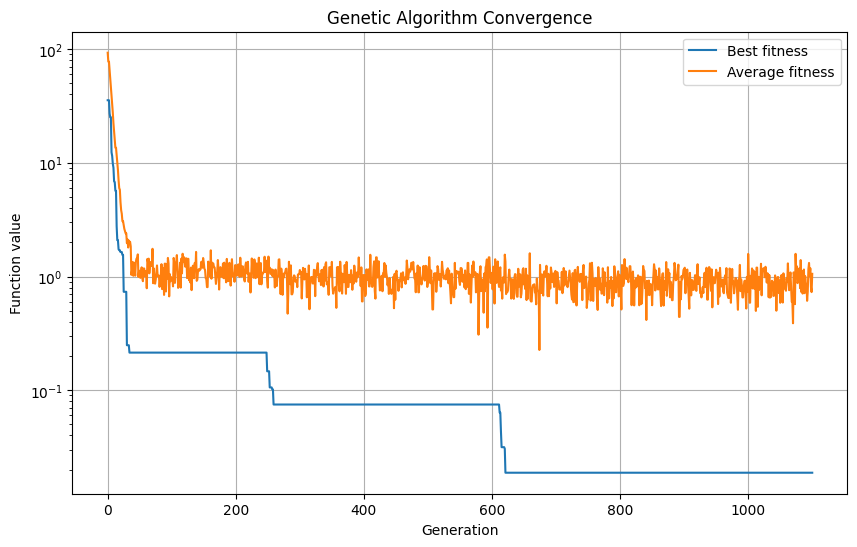

In [11]:
analyze_results(
    best_solution_rastrigin,
    best_fitness_rastrigin,
    best_fitness_history_rastrigin,
    avg_fitness_history_rastrigin
)